# Notebook for Scrape Postal Codes of Canada starting with M

We are using requests, bs4 to scrape the data from Wikipedia page for the neighbour explore project for IBM DS Capstone

## Part 1

In [29]:
# Import packages
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np

from geopy.geocoders import Nominatim 
import folium

from sklearn.cluster import KMeans
from pandas.io.json import json_normalize


import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt

Load the URL and use requests to scrape the data.

Note: The scrped date is July 28th.

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
content = requests.get(url).text

Use BeautifulSoup to clean the scraped file

We checked that this wikipedia page only contains one table.

Use pandas to clean the table

In [4]:
soup = BeautifulSoup(content,'lxml')
table = soup.find_all('table')
df = pd.read_html(str(table))[0]

Show the first 10 rows of the table.

In [5]:
df[0:10]

Postal Code           Borough                                Neighbourhood
0         M1A      Not assigned                                 Not assigned
1         M2A      Not assigned                                 Not assigned
2         M3A        North York                                    Parkwoods
3         M4A        North York                             Victoria Village
4         M5A  Downtown Toronto                    Regent Park, Harbourfront
5         M6A        North York             Lawrence Manor, Lawrence Heights
6         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
7         M8A      Not assigned                                 Not assigned
8         M9A         Etobicoke      Islington Avenue, Humber Valley Village
9         M1B       Scarborough                               Malvern, Rouge

Remove all the rows with Borough column = 'Not assigned'

In [6]:
postal_df = df[ df['Borough'] != 'Not assigned' ]

Check whether Neighbour column contains any 'Not assigned'

In [7]:
postal_df[postal_df['Neighbourhood'] == 'Not assigned']

Empty DataFrame
Columns: [Postal Code, Borough, Neighbourhood]
Index: []

No 'Not assigned' appeared in the Neighbour column after the cleaning.

Print the shape of the cleaned version table.

In [8]:
print('The shape of the postal table scraped from Wikepedia is ', postal_df.shape)

The shape of the postal table scraped from Wikepedia is  (103, 3)


## Part 2

In [9]:
geodata = pd.read_csv('Geospatial_Coordinates.csv')

In [10]:
neighborhoods = pd.merge(postal_df,geodata,on='Postal Code')
neighborhoods 

Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
4           M7A  Downtown Toronto   
..          ...               ...   
98          M8X         Etobicoke   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   
101         M8Y         Etobicoke   
102         M8Z         Etobicoke   

                                         Neighbourhood   Latitude  Longitude  
0                                            Parkwoods  43.753259 -79.329656  
1                                     Victoria Village  43.725882 -79.315572  
2                            Regent Park, Harbourfront  43.654260 -79.360636  
3                     Lawrence Manor, Lawrence Heights  43.718518 -79.464763  
4          Queen's Park, Ontario Provincial Government  43.662301 -79.389494  
..                                                 ...        ...        ...  
98       The Kingsway, Montgomery Road, Old Mill North  43.653654 -79.506944  
99                                Church and Wellesley  43.665860 -79.383160  
100  Business reply mail Processing Centre, South C...  43.662744 -79.321558  
101  Old Mill South, King's Mill Park, Sunnylea, Hu...  43.636258 -79.498509  
102  Mimico NW, The Queensway West, South of Bloor,...  43.628841 -79.520999  

[103 rows x 5 columns]

In [11]:
neighborhoods.Borough.unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

## Part 3

We draw the map for the entire Toronto

In [12]:
address = 'Toronto'
geolocator = Nominatim(user_agent="toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [38]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'],
                                           neighborhoods['Longitude'],
                                           neighborhoods['Borough'],
                                           neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

We Consider all borough with name contains 'Toronto'

In [14]:
dt_data = neighborhoods[ (neighborhoods['Borough'] == 'Downtown Toronto') |
                        (neighborhoods['Borough'] == 'East Toronto')|
                        (neighborhoods['Borough'] == 'West Toronto')|
                        (neighborhoods['Borough'] == 'Central Toronto')].reset_index(drop=True)
address = 'Downtown Toronto'
geolocator = Nominatim(user_agent="toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtow Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtow Toronto are 43.6541737, -79.38081164513409.


Print the map of the neighbourhoods we consider

In [39]:
map_dt = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(dt_data['Latitude'],
                                           dt_data['Longitude'],
                                           dt_data['Borough'],
                                           dt_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dt)  
    
map_dt

In [16]:
dt_data.head()
print('The dataset has size',dt_data.shape)

The dataset has size (39, 5)


We use Foursquare to search for nearby venues.

In [17]:
## include Foursquare credentials
client_id = 'HSFOOGUP2UOTMX3R1KMPZLFMTWQLAJEDDVXFPQTTEF2E1YHI'
client_secret = 'I11LHMK5D1HWOEEFU43APX40EYGT0EWWTWTXYTAQC3IMMIZU'
VERSION = '20180605' # Foursquare API version

In [18]:
## define the function to get nearby venues

def getNearbyVenues(names, latitudes, longitudes, CLIENT_ID,CLIENT_SECRET,radius=500,LIMIT = 50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Use the function to scrapte nearby venues in Toronto

In [19]:
dt_venues = getNearbyVenues(names=
                            dt_data['Neighbourhood'],
                            latitudes=dt_data['Latitude'],
                            longitudes=dt_data['Longitude'],
                            CLIENT_ID = client_id,
                            CLIENT_SECRET = client_secret
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [21]:
print(dt_venues.shape)
dt_venues.groupby('Neighbourhood').count()
print('There are {} uniques categories in Toronto.'.format(len(dt_venues['Venue Category'].unique())))

(1187, 7)
There are 212 uniques categories in Toronto.


We clean the retrieved data and clean it.

In [22]:
# one hot encoding
dt_onehot = pd.get_dummies(dt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dt_onehot['Neighbourhood'] = dt_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [dt_onehot.columns[-1]] + list(dt_onehot.columns[:-1])
dt_onehot = dt_onehot[fixed_columns]

dt_onehot.head()
dt_onehot.shape

dt_grouped = dt_onehot.groupby('Neighbourhood').mean().reset_index()
dt_grouped

dt_grouped.shape

(39, 213)

In [24]:
dt_grouped.head()

Neighbourhood   Airport  \
0                                        Berczy Park  0.000000   
1       Brockton, Parkdale Village, Exhibition Place  0.000000   
2  Business reply mail Processing Centre, South C...  0.000000   
3  CN Tower, King and Spadina, Railway Lands, Har...  0.071429   
4                                 Central Bay Street  0.000000   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0            0.000000        0.000000         0.000000          0.000000   
1            0.000000        0.000000         0.000000          0.000000   
2            0.000000        0.000000         0.000000          0.000000   
3            0.071429        0.142857         0.142857          0.142857   
4            0.000000        0.000000         0.000000          0.000000   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  ...  \
0                  0.0           0.0       0.0         0.02  ...   
1                  0.0           0.0       0.0         0.00  ...   
2                  0.0           0.0       0.0         0.00  ...   
3                  0.0           0.0       0.0         0.00  ...   
4                  0.0           0.0       0.0         0.00  ...   

   Theme Restaurant  Toy / Game Store  Trail  Train Station  \
0               0.0               0.0    0.0            0.0   
1               0.0               0.0    0.0            0.0   
2               0.0               0.0    0.0            0.0   
3               0.0               0.0    0.0            0.0   
4               0.0               0.0    0.0            0.0   

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                           0.02               0.0                    0.0   
1                           0.00               0.0                    0.0   
2                           0.00               0.0                    0.0   
3                           0.00               0.0                    0.0   
4                           0.02               0.0                    0.0   

   Wine Bar  Wine Shop  Yoga Studio  
0      0.00        0.0         0.00  
1      0.00        0.0         0.00  
2      0.00        0.0         0.00  
3      0.00        0.0         0.00  
4      0.02        0.0         0.02  

[5 rows x 213 columns]

We find top 10 venues in each neighbourhood.

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = dt_grouped['Neighbourhood']

for ind in np.arange(dt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dt_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue  \
0                                        Berczy Park           Coffee Shop   
1       Brockton, Parkdale Village, Exhibition Place                  Café   
2  Business reply mail Processing Centre, South C...  Fast Food Restaurant   
3  CN Tower, King and Spadina, Railway Lands, Har...        Airport Lounge   
4                                 Central Bay Street           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                Bakery    Seafood Restaurant              Beer Bar   
1           Coffee Shop             Nightclub        Breakfast Spot   
2         Auto Workshop                  Park         Garden Center   
3       Airport Service      Airport Terminal               Airport   
4        Sandwich Place       Bubble Tea Shop                  Café   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0            Cocktail Bar        Farmers Market            Restaurant   
1  Furniture / Home Store          Climbing Gym               Stadium   
2                  Garden            Restaurant               Brewery   
3           Boat or Ferry       Harbor / Marina   Rental Car Location   
4      Italian Restaurant            Comic Shop           Salad Place   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0           Cheese Shop                  Café                 Museum  
1          Intersection                   Bar     Italian Restaurant  
2            Comic Shop  Gym / Fitness Center            Pizza Place  
3      Sculpture Garden              Boutique            Coffee Shop  
4          Burger Joint            Poke Place            Pizza Place

After we select top 10 venues in each neighbour, we use kclusters to run do the cluster.

We first use elbow method the figure out the number of clusters.

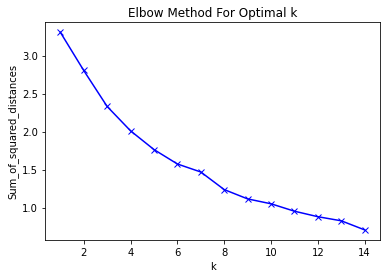

In [30]:
dt_elbow = dt_grouped.drop('Neighbourhood', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dt_elbow)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the plot, we decided to use k = 8

Fit the model

In [31]:
# set number of clusters
kclusters = 8

dt_grouped_clustering = dt_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [33]:
dt_merged = dt_data.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
dt_merged.head()

Postal Code           Borough                                Neighbourhood  \
0         M5A  Downtown Toronto                    Regent Park, Harbourfront   
1         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   
2         M5B  Downtown Toronto                     Garden District, Ryerson   
3         M5C  Downtown Toronto                               St. James Town   
4         M4E      East Toronto                                  The Beaches   

    Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0  43.654260 -79.360636               0           Coffee Shop   
1  43.662301 -79.389494               6           Coffee Shop   
2  43.657162 -79.378937               0           Coffee Shop   
3  43.651494 -79.375418               6                  Café   
4  43.676357 -79.293031               0                 Trail   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                Bakery                  Park                   Pub   
1                 Diner           Yoga Studio    College Auditorium   
2                  Café              Tea Room             Bookstore   
3        Cosmetics Shop           Coffee Shop            Restaurant   
4          Neighborhood                   Pub     Health Food Store   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0               Theater        Breakfast Spot                  Café   
1              Beer Bar         Smoothie Shop        Sandwich Place   
2    Italian Restaurant        Clothing Store               Theater   
3             Gastropub        Farmers Market              Creperie   
4           Yoga Studio      Cuban Restaurant      Doner Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0            Restaurant   Distribution Center             Beer Store  
1         Burrito Place                  Café               Creperie  
2        Cosmetics Shop      Ramen Restaurant   Fast Food Restaurant  
3                 Hotel    Seafood Restaurant       Department Store  
4               Dog Run   Distribution Center         Discount Store

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dt_merged['Latitude'], dt_merged['Longitude'], 
                                  dt_merged['Neighbourhood'], dt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters